In [1]:
import preprocessFERplus as preprocess
import facemeshANN as classifier

In [2]:
data = preprocess.FERdata('challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')

100%|██████████| 35887/35887 [00:38<00:00, 922.61it/s]


In [3]:
# result = data.get_df(sample=True, sample_size=35)
result = data.get_df(mode='ANN')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
100%|██████████| 35887/35887 [07:15<00:00, 82.45it/s] 


In [12]:
result['target'].value_counts()

3    8666
6    6002
4    5427
2    4638
0    4414
5    3798
1     477
Name: target, dtype: int64

In [32]:
list(result[result['usage'] == 'train']['target'].value_counts().index)

[3, 6, 4, 2, 0, 5, 1]

In [24]:
result[result['usage'] == 'train']['target'].value_counts().idxmin()

1

In [5]:
result['target']

0        0
1        0
2        2
3        6
4        2
        ..
33417    0
33418    6
33419    0
33420    3
33421    2
Name: target, Length: 33422, dtype: object

In [6]:
result['usage'].value_counts()

train    26735
test      3347
val       3340
Name: usage, dtype: int64

In [7]:
train_df = result[result['usage'] == 'train'].drop(columns='usage').sample(frac=1, ignore_index=True)
val_df = result[result['usage'] == 'val'].drop(columns='usage').sample(frac=1, ignore_index=True)
test_df = result[result['usage'] == 'test'].drop(columns='usage').sample(frac=1, ignore_index=True)

In [8]:
model = classifier.ANNClassifier(478*3, 8, 0.1)
# model = classifier.ANNClassifier(input_size=48*48*3, output_size=8, dropout=0.3)
print(model)

Using mps device
ANNClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1434, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=8, bias=True)
  )
)


Epoch 100 | tr_loss:1.7983 | va_loss:1.8003 | va_acc:0.2593 | te_loss:1.8029 | te_acc:0.2543: 100%|██████████| 100/100 [30:10<00:00, 17.90s/it]

Result : train_loss:1.7984 | val_loss:1.8005 | val_acc:0.2593 | test_loss:1.8028 | test_acc:0.2543
Done!


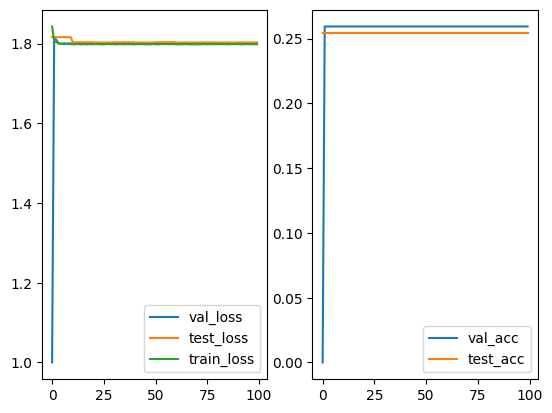

In [9]:
model, test_loss, correct = classifier.trainmodel(model, train_df, val_df, test_df, epochs=100, lr=1e-3, batch_size=32)

In [10]:
classifier.savemodel(model, './model/meshANN.pt')

saving done!


In [9]:
model = classifier.getmodel(model, './model/meshANN.pt')

In [10]:
test_loss, test_acc = classifier.testmodel(model, test_df=test_df)

In [11]:
test_loss

1.8030606091182766

In [33]:
test_df = test_df.sample(frac=1, ignore_index=True)

In [35]:
test_df['feature'][0]

array([[ 0.60054123,  0.65423417, -0.12555163],
       [ 0.67083347,  0.54090023, -0.18205555],
       [ 0.65527451,  0.58076406, -0.11211419],
       ...,
       [ 0.73616219,  0.33571979,  0.08434928],
       [ 0.70586944,  0.36373478,  0.08434928],
       [ 0.73786259,  0.3875975 ,  0.08434928]])

In [41]:
pred = model(test_df['feature'][:1])

AttributeError: 'Series' object has no attribute 'flatten'